In [2]:
from math import floor
import pandas as pd
import os
from binance.client import Client
import datetime, time
import numpy as np

# howLong = 2 * 365
#     # Calculate the timestamps for the binance api function
# untilThisDate = datetime.datetime.now()
# sinceThisDate = untilThisDate - datetime.timedelta(days = howLong)
# client = Client(api_key, api_secret)
#     # Execute the query from binance - timestamps must be converted to strings !
# candle = client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, str(sinceThisDate), str(untilThisDate))

#     # Create a dataframe to label all the columns returned by binance so we work with them later.
# df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
#     # as timestamp is returned in ms, let us convert this back to proper timestamps.
# #self.df.dateTime = pd.to_datetime(self.df.dateTime, unit='ms').dt.strftime(Constants.DateTimeFormat)
# df = df.set_index('dateTime', inplace=True)

#     # Get rid of columns we do not need
# df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol','takerBuyQuoteVol', 'ignore'], axis=1)

df = pd.read_csv("LTCUSDT-5m-2021-11.csv")
df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']

df = df.set_index('open_time')



df = df.drop(['close_time', 'ignore'], axis=1)

df



,open,high,low,close,volume,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
open_time,,,,,,,,,
1635725100000,191.43,192.02,191.37,192.02,2793.815,5.355669e+05,1297,1385.168,2.655765e+05
1635725400000,192.02,193.32,191.93,193.01,10168.770,1.960809e+06,3851,5928.260,1.143253e+06
1635725700000,192.98,193.76,192.92,193.62,8579.165,1.659771e+06,2904,3799.094,7.349429e+05
1635726000000,193.60,193.72,193.02,193.37,4839.350,9.358926e+05,1951,2065.522,3.995075e+05
1635726300000,193.36,193.69,193.31,193.39,4937.114,9.553264e+05,1758,2668.693,5.164217e+05
...,...,...,...,...,...,...,...,...,...
1638315300000,208.33,208.91,208.15,208.77,4036.863,8.414236e+05,1373,1840.337,3.837659e+05
1638315600000,208.78,209.18,208.77,209.00,2471.871,5.165802e+05,1203,1103.075,2.305155e+05
1638315900000,209.00,209.19,207.60,207.73,5946.212,1.237775e+06,2159,1900.718,3.957291e+05


### Calculating MACD

In [3]:
# Get the 26-day EMA of the closing price
k = df['close'].ewm(span=12, adjust=False, min_periods=12).mean()
# Get the 12-day EMA of the closing price
d = df['close'].ewm(span=26, adjust=False, min_periods=26).mean()
# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d
# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s
# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)

#df.index = pd.DatetimeIndex(df['open_time'].to_period('M'))

df.index = pd.to_datetime(df.index, unit='ms')
df.index = pd.DatetimeIndex(df.index).to_period('M')

df_test = df[floor(-0.1*len(df)): -1]
df_train = df[0 : len(df_test)]

TypeError: float() argument must be a string or a real number, not 'Period'

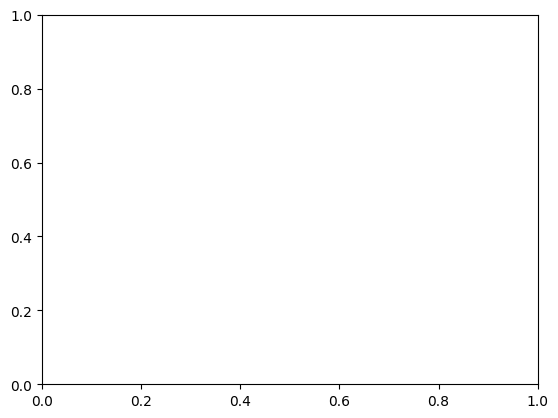

In [3]:
import matplotlib.pyplot as plt

plt.plot(df["macd"][floor(0.75*len(df)):floor(0.85 * len(df))])
plt.show()

### Weak learner

In [9]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import utils

features = df.copy()
target = features['macd'].dropna()
features = features[features["macd"].notna()].drop(['macd', 'macd_h', 'macd_s'], axis=1)

lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(target)
y_transformed

dtree = DecisionTreeClassifier()
dtree = dtree.fit(features, y_transformed)

# tree.plot_tree(dtree, feature_names=features.columns) 

In [19]:
# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from random import random
# contrived dataset
data = df_train['macd'].dropna()[-100:]
# fit model
model = ARIMA(data, order=(2, 3, 1))
model_fit = model.fit()
# make prediction
# yhat = model_fit.predict(len(data), len(data), type='levels')
# print(yhat)

prediction = model_fit.forecast(26)
#df_test[:26]
mean_squared_error(prediction, df_test["macd"][0:26])

1.3053687909848462

In [53]:
prediction

2030-03    0.029022
2030-04    0.077647
2030-05    0.125649
2030-06    0.174529
2030-07    0.223681
2030-08    0.273345
2030-09    0.323425
2030-10    0.373959
2030-11    0.424931
2030-12    0.476349
2031-01    0.528208
2031-02    0.580512
2031-03    0.633258
2031-04    0.686447
2031-05    0.740080
2031-06    0.794156
2031-07    0.848674
2031-08    0.903636
2031-09    0.959041
2031-10    1.014889
2031-11    1.071181
2031-12    1.127915
2032-01    1.185093
2032-02    1.242713
2032-03    1.300777
2032-04    1.359284
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
#RNN - наверное слишком сильно для слабого ученика

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

def get_train_test(url, split_percent=0.8):
    df = pd.read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data
 
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
 
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
 
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 12
train_data, test_data, data = get_train_test(sunspots_url)
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)
 
# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
 
# Print error
print_error(trainY, testY, train_predict, test_predict)
 
#Plot result
plot_result(trainY, testY, train_predict, test_predict)

# Bagging
В случае временных рядов берется разное количество обучающих примеров у слабых учеников

In [6]:
num_of_models = 10
prediction_size = 26
errors = np.empty(num_of_models)
predictions = np.empty((num_of_models, prediction_size))
#models = [num_of_models]


for i in range(1, num_of_models):
    data = df_train['macd'].dropna()[-100 * i:]
    # fit model
    models = ARIMA(data, order=(2, 3, 1))
    model_fit = models.fit()
    # make prediction

    predictions[i - 1] = model_fit.forecast(prediction_size)
    print(str(mean_squared_error(predictions[i - 1], df_test["macd"][0:26])) + '\n')

ensemble_prediction = predictions.mean(0)
print('ensemble prediction: ' + str(mean_squared_error(ensemble_prediction, df_test["macd"][0:26])))

1.3053687909848462

1.1825068860096115

1.3822840918752244

1.3387232595428888



/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.28067222201958



/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.205049829530543

1.2870085267975098



/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.288185105801851

1.3491008763622536

ensemble prediction: 1.1206614667387744


In [70]:
import warnings
from sklearn.exceptions import DataConversionWarning


def baggingARIMA():
    num_of_models = 10
    prediction_size = 26
    num_of_steps = 100
    errors = np.empty(num_of_models)
    predictions = np.empty((num_of_models, prediction_size))
    #models = [num_of_models]
    counter = 0
    for step in range(1, num_of_steps):
        temp_test = df[floor(-0.009* step * len(df)): -1]
        temp_train = df[0 : -len(temp_test)]
        minSoleModel = 10
        for i in range(1, num_of_models):
            data = temp_train['macd'].dropna()[-100 * i:]
            # fit model
            models = ARIMA(data, order=(2, 3, 1))
            model_fit = models.fit()
            # make prediction

            predictions[i - 1] = model_fit.forecast(prediction_size)
            minSoleModel = min(mean_squared_error(predictions[i - 1], temp_test["macd"][0:26]), minSoleModel)

        ensemble_prediction = predictions.mean(0)
        ensemble_error = mean_squared_error(ensemble_prediction, temp_test["macd"][0:26])
        print('best basic model prediction: ' + str(minSoleModel) + '  ensemble prediction: ' + str(ensemble_error))
        if(ensemble_error < minSoleModel): counter += 1

    print('\n{0} out of {1} experiments showed better results with ensemble than with any basic model'.format(counter, num_of_steps))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    baggingARIMA()

best basic model prediction: 0.8193636981244415  ensemble prediction: 0.7236783941527759
best basic model prediction: 1.8304812213807273  ensemble prediction: 2.239989334384835
best basic model prediction: 0.9261651993164146  ensemble prediction: 1.0479033344670328
best basic model prediction: 0.019802896109778735  ensemble prediction: 0.03670702973328946
best basic model prediction: 3.688536345394365  ensemble prediction: 3.4681407932314054
best basic model prediction: 0.06309060869286696  ensemble prediction: 0.08990957015139249
best basic model prediction: 0.014783129492511315  ensemble prediction: 0.012484577890522246
best basic model prediction: 0.1160572931871838  ensemble prediction: 0.2255134305370293
best basic model prediction: 0.10151909730225868  ensemble prediction: 0.11966471551367651
best basic model prediction: 0.4169172868959827  ensemble prediction: 0.38203710155591863
best basic model prediction: 0.6685925943680832  ensemble prediction: 0.5903670930950984
best basic 

# Boosting

In [59]:
# Генерация синтетических данных
np.random.seed(42)
X = np.random.rand(100, 1)
y = 2 * X.squeeze() + 1 + 0.1 * np.random.randn(100)

# Определение базовой модели (слабого ученика)
class DecisionStump:
    def __init__(self):
        self.split_feature = None
        self.split_threshold = None
        self.left_value = None
        self.right_value = None

    def fit(self, X, y):
        # Простой ступенчатый классификатор
        self.split_feature = 0
        self.split_threshold = np.median(X)
        self.left_value = np.mean(y[np.where(X <= self.split_threshold)[0]])
        self.right_value = np.mean(y[np.where(X > self.split_threshold)[0]])

    def predict(self, X):
        return np.where(X[:, self.split_feature] <= self.split_threshold,
                        self.left_value, self.right_value)

# Определение класса для градиентного бустинга
class GradientBoostingRegressorHomemade:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []

    def fit(self, X, y):
        # Инициализация предсказаний нулевым значением
        predictions = np.zeros_like(y)

        # Обучение базовых моделей и обновление предсказаний
        for _ in range(self.n_estimators):
            estimator = DecisionStump()
            residual = y - predictions
            estimator.fit(X, residual)
            predictions += self.learning_rate * estimator.predict(X)
            self.estimators.append(estimator)

    def predict(self, X):
        # Суммируем предсказания от всех базовых моделей
        predictions = np.sum((self.learning_rate * estimator.predict(X)
                             for estimator in self.estimators), axis=0)
        return predictions

# Использование градиентного бустинга
gb_regressor = GradientBoostingRegressorHomemade(n_estimators=100, learning_rate=0.1)
gb_regressor.fit(X, y)
basic_model = GradientBoostingRegressorHomemade(n_estimators=1, learning_rate=0.1)
basic_model.fit(X, y)


from sklearn.metrics import mean_squared_error


# Генерация случайных данных
np.random.seed(59)
X = np.random.rand(100, 1)
y = 2 * (X.squeeze())**2 +  5 * X.squeeze() +  1 + 0.1 * np.random.randn(100)

# Разделение данных на обучающую и тестовую выборки
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Обучение модели с n_estimators=1
model_1 = GradientBoostingRegressorHomemade(n_estimators=1, learning_rate=0.1)
model_1.fit(X_train, y_train)

# Обучение модели с n_estimators=100
model_100 = GradientBoostingRegressorHomemade(n_estimators=100, learning_rate=0.1)
model_100.fit(X_train, y_train)

# Предсказания на тестовой выборке
predictions_1 = model_1.predict(X_test)
predictions_100 = model_100.predict(X_test)

# Вычисление MSE
mse_1 = mean_squared_error(y_test, predictions_1)
mse_100 = mean_squared_error(y_test, predictions_100)

# Вывод результатов
print(f"MSE for n_estimators=1: {mse_1}")
print(f"MSE for n_estimators=100: {mse_100}")

MSE for n_estimators=1: 19.657759587971253
MSE for n_estimators=100: 0.8697999402837402


/tmp/ipykernel_6715/2097251924.py:46: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  predictions = np.sum((self.learning_rate * estimator.predict(X)


# Voting

In [71]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression


def differentModelsPredictions(prediction_size, data, test_data):

    num_of_models = 5
    predictions = np.empty((num_of_models, prediction_size))
    # ARIMA
    model = ARIMA(data, order=(2, 3, 1))
    model_fit = model.fit()
    predictions[0] =  model_fit.forecast(prediction_size)
    CurMin = mean_squared_error(predictions[0], test_data)

    #AR
    model = AutoReg(data, lags=2)
    model_fit = model.fit()
    predictions[1] = model_fit.forecast(prediction_size)
    CurMin = min(CurMin, mean_squared_error(predictions[1], test_data))

    #MA
    model = ARIMA(data, order=(0, 0, 1))
    model_fit = model.fit()
    predictions[2] = model_fit.forecast(prediction_size)
    CurMin = min(CurMin, mean_squared_error(predictions[2], test_data))

    #ARMA
    model = ARIMA(data, order=(2, 0, 1))
    model_fit = model.fit()
    predictions[3] = model_fit.forecast(prediction_size)
    CurMin = min(CurMin, mean_squared_error(predictions[3], test_data))

    #SARIMA
    model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit()
    predictions[4] = model_fit.forecast(prediction_size)
    CurMin = min(CurMin, mean_squared_error(predictions[4], test_data))

    return predictions, CurMin



temp_test = df[floor(-0.5* len(df)): ]
temp_train = df[0 : -len(temp_test)]
predictions_for_LR, mi = differentModelsPredictions(80, temp_train['macd'].dropna(), temp_test["macd"][0:80])
lr = LinearRegression().fit(predictions_for_LR.reshape(80, 5), temp_test["macd"][0:80])

predictionsFinal, mi = differentModelsPredictions(26, df_train['macd'].dropna()[-100 * 5:], df_test["macd"][0:26])
ensemble_prediction = predictionsFinal.mean(0)
ensemble_error = mean_squared_error(ensemble_prediction, df_test["macd"][0:26])
print('best basic model prediction: ' + str(mi) + '  ensemble prediction: ' + str(ensemble_error) + '\n')

final_result = mean_squared_error(lr.predict(predictionsFinal.reshape(26, 5)), df_test["macd"][0:26])
print('meta learner final result: ' + str(final_result))


/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14879D+00    |proj g|=  2.53863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     12      1     0     0   3.048D-04  -1.149D+00
  F =  -1.1487925938544030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/olegsandrr/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77219D+00    |proj g|=  1.41377D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     12      1     0     0   3.241D-03  -1.772D+00
  F =  -1.7721958259936590     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
best basic model prediction: 0.23949592946788167  ensemble prediction: 0.3907426613901024



 This problem is unconstrained.


In [ ]:
# params = {'num_leaves': 30,
#           'n_estimators': 400,
#           'max_depth': 8,
#           'min_child_samples': 200,
#           'learning_rate': 0.1,
#           'subsample': 0.50,
#           'colsample_bytree': 0.75
#          }


# model = lgb.LGBMRegressor(**params)
# model = model.fit(x_train.drop(columns=['timestamp']), y_train)

# Real-time predictions

Цикл, где я предсказываю некое количество шагов, потом двигаюсь на один период вперед и добавляю его к модели?